In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def read_log(fname):
    with open(fname, "r") as f:
        log = f.read()
    return log

def parse(log):
    pattern = r"iter (\d+): loss ([\d\.]+), time ([\d\.]+)ms, time_process ([\d\.]+)ms,"
    matches = re.findall(pattern, log)

    # Convert to lists of ints and floats
    iters = [int(m[0]) for m in matches]
    losses = [float(m[1]) for m in matches]
    time = [float(m[2]) for m in matches]
    time_process = [float(m[3]) for m in matches]
    return iters, losses, time_process

def parse_step(log):
    step_matches = re.findall(r"step (\d+): train loss ([\d\.]+), val loss ([\d\.]+)", log)
    steps = [int(m[0]) for m in step_matches]
    train_losses = [float(m[1]) for m in step_matches]
    val_losses = [float(m[2]) for m in step_matches]
    return steps, train_losses, val_losses

In [3]:
import re
import pandas as pd

def parse_steps_df(log: str) -> pd.DataFrame:
    # "step 1000: train loss 4.5372, val loss 4.5246"
    matches = re.findall(r"step (\d+): train loss ([\d\.]+), val loss ([\d\.]+)", log)
    return pd.DataFrame(matches, columns=["step", "train_loss", "val_loss"]).astype(float)

def parse_iters_df(log: str) -> pd.DataFrame:
    # "iter 990: loss 4.5057, time 3599.67ms, time_process 3593.28ms, time_perf 3599.67ms, mfu 33.93%"
    matches = re.findall(
        r"iter (\d+): loss ([\d\.]+), time ([\d\.]+)ms, time_process ([\d\.]+)ms, time_perf ([\d\.]+)ms, mfu ([\-\d\.]+)%",
        log
    )
    df = pd.DataFrame(matches, columns=["iter", "loss", "time_ms", "time_process_ms", "time_perf_ms", "mfu_pct"]).astype(float)
    df["time_s"] = df["time_ms"] / 1000
    return df


In [4]:
log = open('train_AdamW_3.log').read()

steps_df = parse_steps_df(log)
iters_df = parse_iters_df(log)
steps_df['optimizer'] = 'AdamW'
iters_df['optimizer'] = 'AdamW'
steps_df['seed'] = 0
iters_df['seed'] = 0

log2 = open('train_AdamW_2.log').read()

steps_df2 = parse_steps_df(log2)
iters_df2 = parse_iters_df(log2)
steps_df2['optimizer'] = 'AdamW'
iters_df2['optimizer'] = 'AdamW'
steps_df2['seed'] = 1
iters_df2['seed'] = 1
steps_adamw = pd.concat([steps_df, steps_df2], axis=0)
iters_adamw = pd.concat([iters_df, iters_df2], axis=0)

In [5]:
logp = open('train_AdamW+_3_eps1e-8.log').read()

steps_dfp = parse_steps_df(logp)
iters_dfp = parse_iters_df(logp)
steps_dfp['optimizer'] = 'AdamW+'
iters_dfp['optimizer'] = 'AdamW+'
steps_dfp['seed'] = 0
iters_dfp['seed'] = 0

log2p = open('train_AdamW+_2_eps1e-8.log').read()

steps_df2p = parse_steps_df(log2p)
iters_df2p = parse_iters_df(log2p)
steps_df2p['optimizer'] = 'AdamW+'
iters_df2p['optimizer'] = 'AdamW+'
steps_df2p['seed'] = 1
iters_df2p['seed'] = 1
steps_adamwp = pd.concat([steps_dfp, steps_df2p], axis=0)
iters_adamwp = pd.concat([iters_dfp, iters_df2p], axis=0)

In [16]:
df_steps = pd.concat([steps_adamw, steps_adamwp], axis=0)
df_iters = pd.concat([iters_adamw, iters_adamwp], axis=0)

In [17]:
agg = df_steps.groupby(['step', 'optimizer']).agg(
    val_loss_avg = ("val_loss", "mean"),
    train_loss_avg = ("train_loss", "mean")
).reset_index()

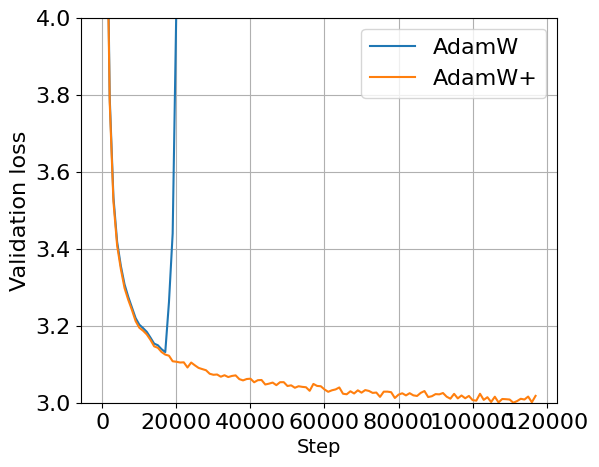

In [18]:
sns.lineplot(
    data=agg,
    x="step",
    y="val_loss_avg",
    hue="optimizer"
)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Validation loss", fontsize=16)
plt.ylim([3, 4])
plt.grid(True)
plt.legend(fontsize=16)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.gcf().set_size_inches(5.5, 4.5)
plt.tight_layout(pad=0.1)
# plt.savefig("nanogpt.pdf",
#             dpi=300,  # facecolor='w', edgecolor='w',
#             orientation='portrait',
#             format='pdf')
plt.show()

In [9]:
timew = df_iters[df_iters['optimizer'] == 'AdamW']['time_ms']
timewp = df_iters[df_iters['optimizer'] == 'AdamW+']['time_ms']

In [10]:
df_iters["cutime_process_ms"] = (
    df_iters.groupby(["seed", "optimizer"])["time_process_ms"].cumsum()
)
df_iters["cutime_perf_ms"] = (
    df_iters.groupby(["seed", "optimizer"])["time_process_ms"].cumsum()
)
df_iters["cutime_s"] = (
    df_iters.groupby(["seed", "optimizer"])["time_s"].cumsum()
)

In [11]:
agg_time = df_iters.groupby(['iter', 'optimizer']).agg(
    time_process_ms_avg = ("cutime_process_ms", "mean"),
    time_perf_ms_avg = ("cutime_perf_ms", "mean"),
    time_s_avg = ("cutime_s", "mean"),
).reset_index()



In [12]:
agg_time = agg_time[agg_time['iter'] <= 40000]

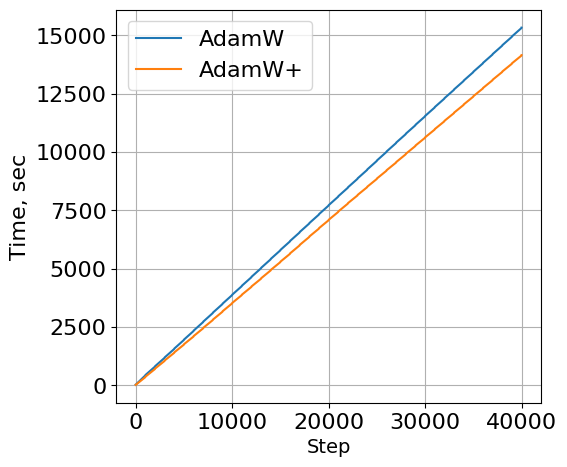

In [13]:
sns.lineplot(
    data=agg_time,
    x="iter",
    y="time_s_avg",
    hue="optimizer"
)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Time, sec", fontsize=16)
# plt.ylim([3, 4])
plt.grid(True)
plt.legend(fontsize=16)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.gcf().set_size_inches(5.5, 4.5)
plt.tight_layout(pad=0.1)
# plt.savefig("nanogpt_time.pdf",
#             dpi=300,  # facecolor='w', edgecolor='w',
#             orientation='portrait',
#             format='pdf')
plt.show()

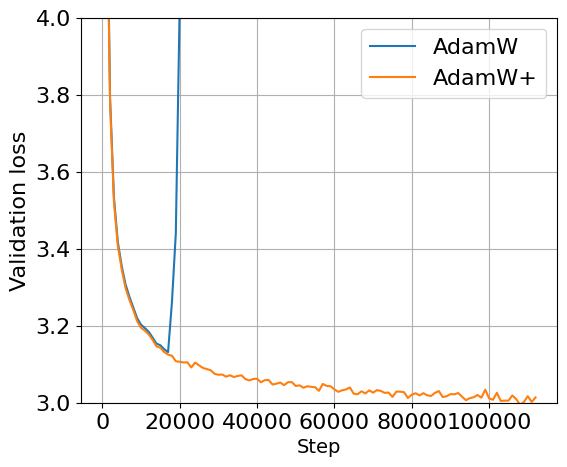

In [15]:
sns.lineplot(
    data=agg,
    x="step",
    y="val_loss_avg",
    hue="optimizer"
)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Validation loss", fontsize=16)
plt.ylim([3, 4])
plt.grid(True)
plt.legend(fontsize=16)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.gcf().set_size_inches(5.5, 4.5)
plt.tight_layout(pad=0.1)
plt.savefig("nanogpt.pdf",
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')
plt.show()

In [13]:
log_adamw = read_log('train_AdamW_3.log')
parse(log_adamw)[1]

[10.9578,
 10.2309,
 9.6741,
 9.3534,
 9.147,
 8.8363,
 8.6572,
 8.58,
 8.1525,
 7.9005,
 8.0554,
 7.6042,
 7.4238,
 7.3682,
 7.3134,
 7.0192,
 6.825,
 6.8102,
 6.9252,
 6.4172,
 6.6043,
 6.6791,
 6.5027,
 6.4437,
 6.2117,
 6.2939,
 6.3904,
 6.0448,
 6.3692,
 6.2767,
 6.0321,
 6.2367,
 6.0489,
 6.0776,
 6.0177,
 6.1381,
 5.7737,
 6.0599,
 6.1207,
 5.8505,
 5.9092,
 5.8159,
 5.8978,
 5.7785,
 5.7104,
 5.6258,
 5.6397,
 5.6746,
 5.6831,
 5.7698,
 5.6822,
 5.5334,
 5.5436,
 5.5107,
 5.4265,
 5.344,
 5.4575,
 5.4355,
 5.4406,
 5.5033,
 5.4661,
 5.2448,
 5.4605,
 5.5189,
 5.3004,
 5.2148,
 5.3694,
 5.131,
 5.1917,
 5.1718,
 5.2008,
 5.2103,
 5.1898,
 4.7848,
 4.9314,
 5.0219,
 4.77,
 5.0117,
 4.912,
 5.0681,
 4.9775,
 5.0372,
 5.0708,
 4.978,
 4.7958,
 4.7801,
 4.6289,
 5.0403,
 4.6191,
 4.8362,
 4.7347,
 4.7799,
 4.9129,
 4.8966,
 4.6523,
 4.5781,
 4.5912,
 4.6039,
 4.4963,
 4.5057,
 4.6381,
 4.4408,
 4.7175,
 4.4748,
 4.4676,
 4.4893,
 4.4471,
 4.5964,
 4.4713,
 4.2855,
 4.0597,
 4.4473,


In [10]:
log_adamw = read_log('train_AdamW_3.log')
steps1, train_losses1, val_losses1 = parse_step(log_adamw)

# Create a DataFrame
df1 = pd.DataFrame({
    "step": steps1,
    "train_loss": train_losses1,
    "val_loss": val_losses1,
    "optimzier": "AdamW",
    "seed": 0
})
log_adamw2 = read_log('train_AdamW_2.log')
steps2, train_losses2, val_losses2 = parse_step(log_adamw2)

# Create a DataFrame
df2 = pd.DataFrame({
    "step": steps2,
    "train_loss": train_losses2,
    "val_loss": val_losses2,
    "optimzier": "AdamW",
    "seed": 1
})
df_adamW = pd.concat([df1, df2], axis=0)

In [11]:
df_adamW

,step,train_loss,val_loss,optimzier,seed
0,0,10.9548,10.9562,AdamW,0
1,1000,4.5372,4.5246,AdamW,0
2,2000,3.7920,3.7975,AdamW,0
3,3000,3.5201,3.5251,AdamW,0
4,4000,3.4113,3.4069,AdamW,0
...,...,...,...,...,...
41,41000,7.5673,7.5670,AdamW,1
42,42000,7.5689,7.5652,AdamW,1
43,43000,7.5875,7.5905,AdamW,1
44,44000,7.5623,7.5670,AdamW,1


In [ ]:
log_adamwp = read_log('train_AdamW+_3.log')
iter_adamw = parse(log_adamw)
iter_adamwp = parse(log_adamwp)

step_adamw1 = parse_step(log_adamw)
step_adamwp1 = parse_step(log_adamwp)

In [5]:
log_adamw = read_log('train_AdamW_2.log')
log_adamwp = read_log('train_AdamW+_2.log')
iter_adamw = parse(log_adamw)
iter_adamwp = parse(log_adamwp)

step_adamw2 = parse_step(log_adamw)
step_adamwp2 = parse_step(log_adamwp)

In [6]:
combined_w = [np.array(step_adamw1[0][:41]), (np.array(step_adamw1[1][:41]) + np.array(step_adamw2[1][:41]))/2, (np.array(step_adamw1[2][:41]) + np.array(step_adamw2[2][:41]))/2]
combined_wp = [np.array(step_adamwp1[0][:41]), (np.array(step_adamw1[1][:41]) + np.array(step_adamwp2[1][:41]))/2, (np.array(step_adamwp1[2][:41]) + np.array(step_adamwp2[2][:41]))/2]

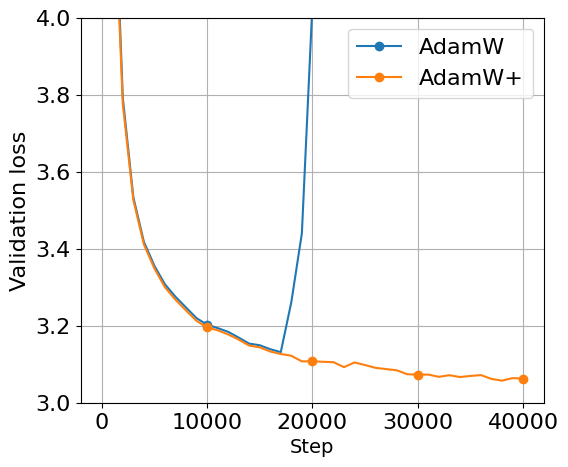

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(combined_w[0], combined_w[2], linestyle='-', marker='o', markevery=10, label='AdamW')
plt.plot(combined_wp[0], combined_wp[2], linestyle='-', marker='o', markevery=10, label='AdamW+')
plt.xlabel("Step", fontsize=14)
plt.ylabel("Validation loss", fontsize=16)
plt.ylim([3, 4])
plt.grid(True)
plt.legend(fontsize=16)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.gcf().set_size_inches(5.5, 4.5)
plt.tight_layout(pad=0.1)
plt.savefig("nanogpt.pdf",
            dpi=300,  # facecolor='w', edgecolor='w',
            orientation='portrait',
            format='pdf')
plt.show()

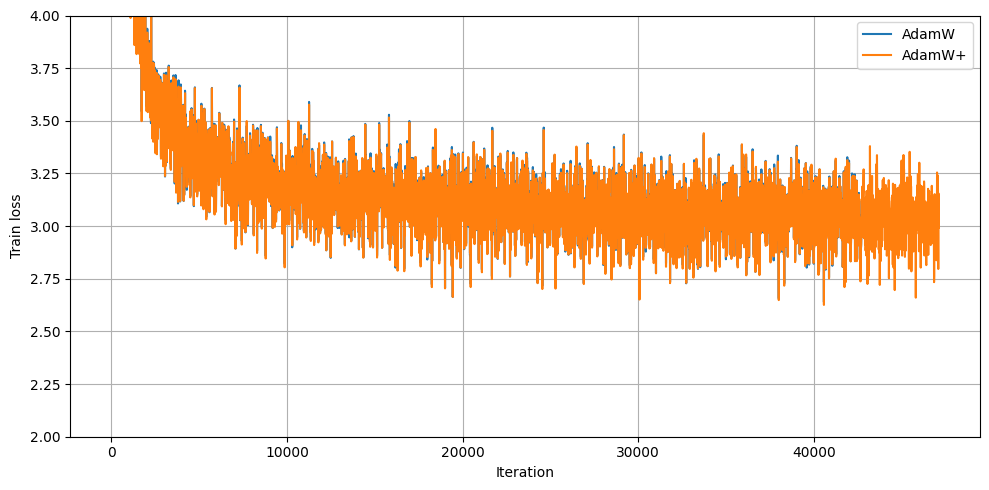

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(iter_adamw[0], iter_adamw[1], linestyle='-', label='AdamW')
plt.plot(iter_adamwp[0], iter_adamwp[1], linestyle='-', label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.ylim([2, 4])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

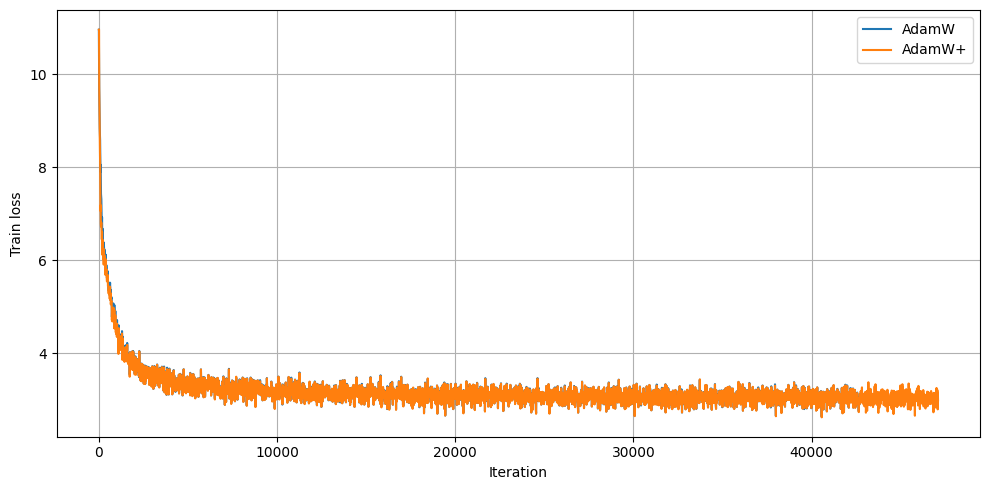

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(iter_adamw[0], iter_adamw[1], linestyle='-', label='AdamW')
plt.plot(iter_adamwp[0], iter_adamwp[1], linestyle='-', label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Train loss")
# plt.ylim([3, 4])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
runtime_adamw = np.cumsum(step_adamw1[2])
runtime_adamwp = np.cumsum(step_adamwp1[2])

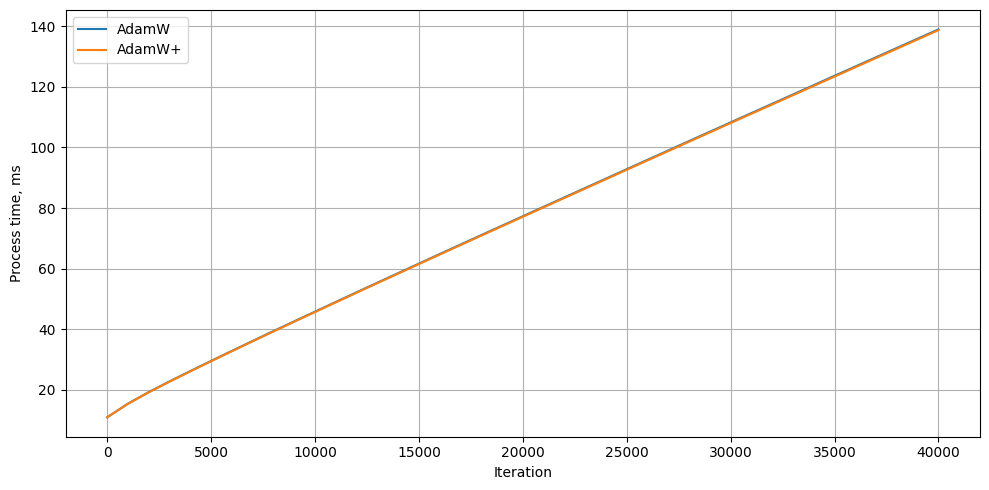

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(combined_w[0][:42], runtime_adamw[:41], linestyle='-', label='AdamW')
plt.plot(combined_wp[0][:42], runtime_adamwp[:41], linestyle='-', label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Process time, ms")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

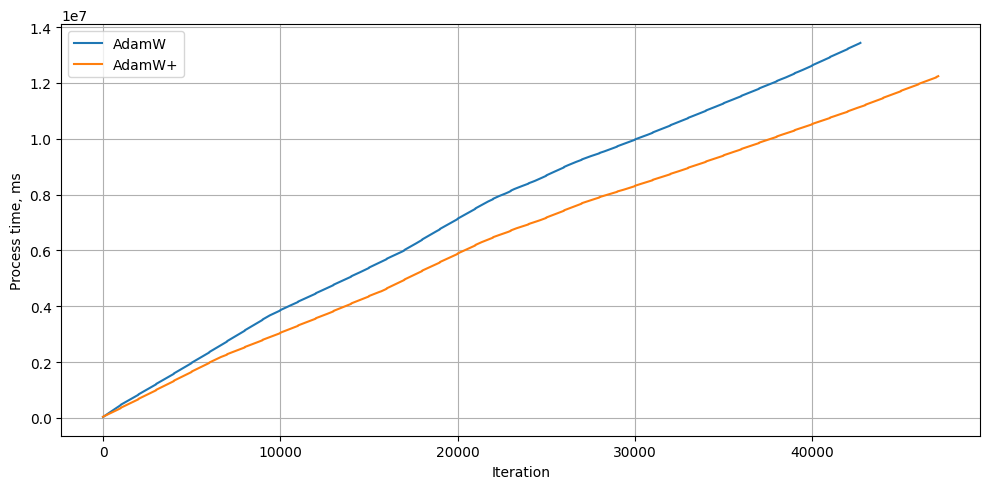

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(iter_adamw[0], runtime_adamw, linestyle='-', label='AdamW')
plt.plot(iter_adamwp[0], runtime_adamwp, linestyle='-', label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Process time, ms")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

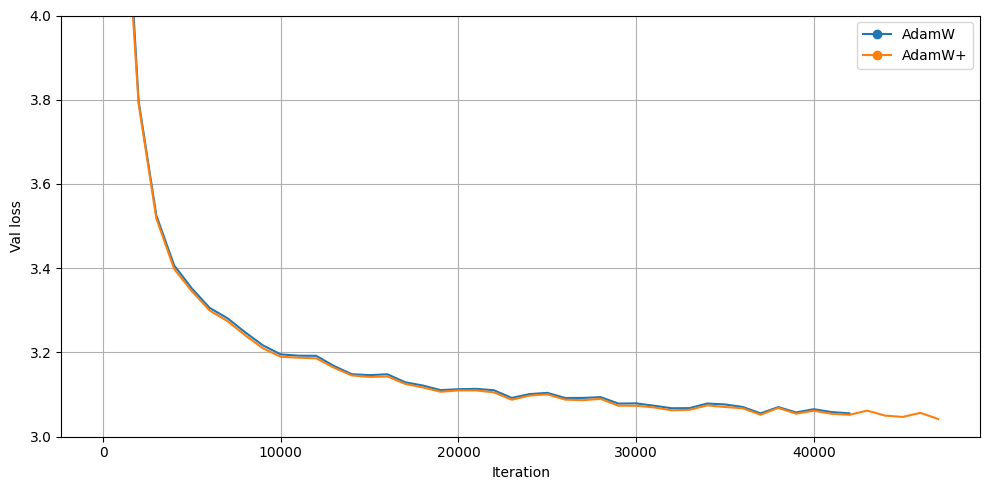

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(step_adamw[0], step_adamw[2], linestyle='-', marker='o', markevery=10000, label='AdamW')
plt.plot(step_adamwp[0], step_adamwp[2], linestyle='-', marker='o', markevery=10000, label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Val loss")
plt.ylim([3, 4])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

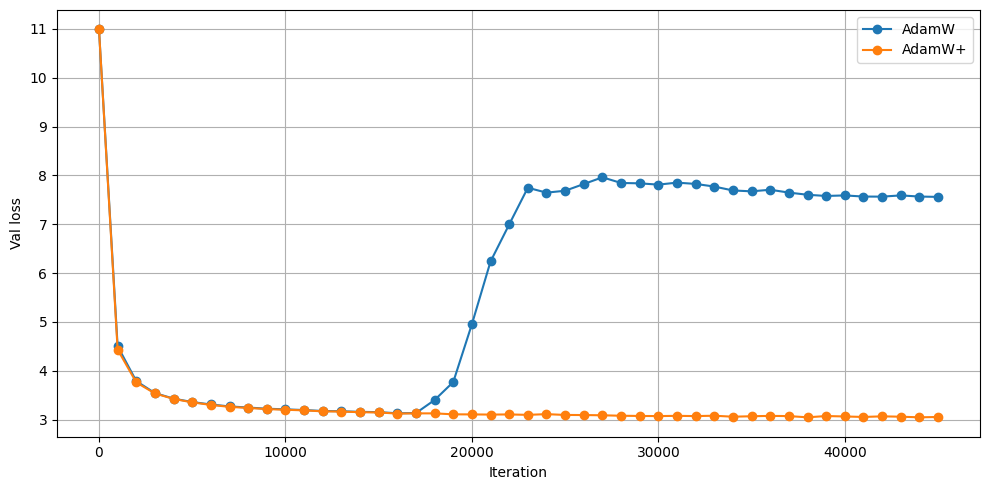

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(step_adamw[0], step_adamw[2], linestyle='-', marker='o', label='AdamW')
plt.plot(step_adamwp[0], step_adamwp[2], linestyle='-', marker='o', label='AdamW+')
plt.xlabel("Iteration")
plt.ylabel("Val loss")
# plt.ylim([3, 4])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
(np.array(step_adamw[2]) - np.array(step_adamwp[2]))

array([0.    , 0.0692, 0.0259, 0.0077, 0.005 , 0.0072, 0.009 , 0.0086,
       0.0084, 0.0071, 0.0086, 0.0065, 0.0075, 0.0064, 0.0072, 0.0066,
       0.0067, 0.006 , 0.2741, 0.6611, 1.8466, 3.1349, 3.8902, 4.6504,
       4.5355, 4.5908, 4.7301, 4.8729, 4.7664, 4.7631, 4.7392, 4.7755,
       4.7537, 4.6926, 4.6325, 4.6054, 4.6303, 4.5766, 4.5571, 4.5061,
       4.5261, 4.5131, 4.4988, 4.5313, 4.5206, 4.5066])